https://www.kaggle.com/thexyzt/keeping-it-simple-by-xyzt

# Introduction

In this notebook, I go through how I worked to find a decent solution for this challenge using simple uncomplicated techniques. No machine learning, no fancy black-box models. Throw away your ARIMAs and Gradient Boosts. Think simple.

# Setup and Loading Data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 12)

PATH = "data/demand-forecasting/"
train = pd.read_csv(f"{PATH}/train.csv", low_memory=False, 
                    parse_dates=['date'], index_col=['date'])
test = pd.read_csv(f"{PATH}/test.csv", low_memory=False, 
                   parse_dates=['date'], index_col=['date'])
sample_sub = pd.read_csv(f"{PATH}/sample_submission.csv")

# Make the sample submission (Score: 48.75440)
# sample_sub.to_csv("submission.csv", index=False)

In [3]:
train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [4]:
test.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


In [5]:
sample_sub.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


# A "Dumb" Prediction

Find the average of sales of an item at a store on the day and month of sales and use that as the prediction. This effectively gives us a sample size of 5 (since the training set is five years long) to find the mean. This is clearly a sub-optimal solution because almost no thought goes into it. But it is helpful to code such solutions to get acquainted with the "Getting Data -> Submitting Prediction" pipeline from start to finish, and generally getting a feel for the data. It also provides a helpful benchmark for future solutions. 

*Any method that scores worse than this prediction is probably doing something incredibly wrong.*

**Note: The following code block takes > 1 hour to run. It is extremely inefficient.**

In [ ]:
%%time
def dumb_prediction(train, test, submission):
    for _, row in test.iterrows():
        item, store = row['item'], row['store']
        day, month = row.name.day, row.name.month
        itemandstore = (train.item == item) & (train.store == store)
        dayandmonth = (train.index.month == month) & (train.index.day == day)
        train_rows = train.loc[itemandstore & dayandmonth]
        pred_sales = int(round(train_rows.mean()['sales']))
        submission.at[row['id'], 'sales'] = pred_sales
    return submission

dumb_pred = dumb_prediction(train, test, sample_sub.copy())
dumb_pred.to_csv("dumb_submission.csv", index=False)

### This solution gets a score of 22.13108.
Nothing impressive, but not completely terrible either. Pretty much the kind of error you can expect for such a silly model.

# Slightly Better Prediction

The previous method simply took the historical average of an item (on the same date and at the same store) and used it to predict the sales on the test set. We can improve this by understanding the data better. Is the a difference between sales on different days? That is, Mondays vs. Fridays, Weekends vs Weekdays? Are there special days without sales? Is there a difference between these stores? Is there a difference between the items?

To understand these trend, we need to dive into the data!

## Exploring the data

In [6]:
# Expand dataframe with more useful columns
def expand_df(df):
    data = df.copy()
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofweek'] = data.index.dayofweek
    return data

data = expand_df(train)
display(data)

grand_avg = data.sales.mean()
print(f"The grand average of sales in this dataset is {grand_avg:.4f}")

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5
2013-01-06,1,1,12,6,1,2013,6
...,...,...,...,...,...,...,...
2017-12-26,10,50,41,26,12,2017,1
2017-12-27,10,50,63,27,12,2017,2


The grand average of sales in this dataset is 52.2503


### Changes by year

All items and stores seem to enjoy a similar growth in sales over the years.

In [7]:
agg_year_item = pd.pivot_table(data, index='year', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(data, index='year', columns='store',
                                values='sales', aggfunc=np.mean).values

In [8]:
pd.pivot_table(data, index='year', columns='item',
                               values='sales', aggfunc=np.mean)

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
year,,,,,,,,,,,,,,,,,,,,,
2013,18.280274,48.793425,30.523836,18.440822,15.238630,48.773151,48.876712,63.952055,42.823014,60.841370,...,18.283562,30.580274,42.785753,24.590137,67.050685,48.993151,18.298082,42.681918,24.293973,54.928767
2014,21.034795,56.112055,35.042192,21.104110,17.498356,56.087397,55.995068,73.784110,49.195616,70.114247,...,21.021644,35.188493,49.049315,28.174521,77.086301,56.138630,21.069589,49.272055,28.208219,63.214521
2015,22.056712,58.574795,36.761096,22.071233,18.326027,58.377808,58.613425,76.911233,51.626575,73.087671,...,22.075616,36.835068,51.231507,29.398630,80.620548,58.514795,21.986849,51.373973,29.498356,65.863836
2016,23.831694,63.508197,39.560383,23.831967,19.957104,63.516940,63.392623,83.260656,55.567486,79.375410,...,23.821311,39.702459,55.513934,31.803005,87.245628,63.639617,23.813388,55.516667,31.616667,71.432787
2017,24.699452,65.868767,41.315616,24.598082,20.769041,65.750411,65.764110,86.824932,57.725205,82.701644,...,24.803562,41.126027,57.879726,33.018082,90.899452,65.899452,24.843836,57.908219,33.053151,73.955890


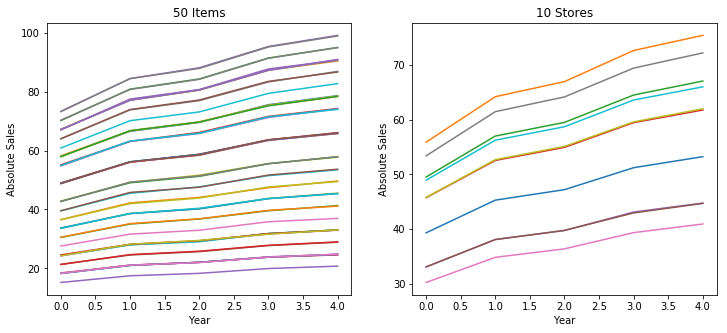

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item)
plt.title("50 Items")
plt.xlabel("Year")
plt.ylabel("Absolute Sales")
plt.subplot(122)
plt.plot(agg_year_store)
plt.title("10 Stores")
plt.xlabel("Year")
plt.ylabel("Absolute Sales")
plt.show()

In [10]:
agg_year_item / agg_year_item.mean(0)

array([[0.83165547, 0.8330582 , 0.83305992, 0.83786717, 0.83008878,
        0.8337128 , 0.83509412, 0.83112259, 0.83333393, 0.83089306,
        0.83379112, 0.83521087, 0.8320751 , 0.83351331, 0.83265115,
        0.8330264 , 0.83635094, 0.83416504, 0.83242056, 0.83163784,
        0.8365371 , 0.83428403, 0.83044268, 0.83517717, 0.83042135,
        0.83057463, 0.832802  , 0.8328918 , 0.83229126, 0.83249004,
        0.83300022, 0.83113917, 0.83241205, 0.82866929, 0.83242508,
        0.83109396, 0.82784388, 0.83459334, 0.83171346, 0.83239068,
        0.83102796, 0.8335574 , 0.8341596 , 0.83648813, 0.83209543,
        0.8355312 , 0.83164222, 0.8311869 , 0.82818273, 0.83378062],
       [0.95697153, 0.95801038, 0.9563754 , 0.95887486, 0.95318208,
        0.95874022, 0.9567164 , 0.95890023, 0.9573445 , 0.95753006,
        0.95508098, 0.95715164, 0.95856765, 0.95550476, 0.95891718,
        0.95722481, 0.95862569, 0.9576628 , 0.95849078, 0.9572078 ,
        0.95708021, 0.95850651, 0.95612989, 0.9

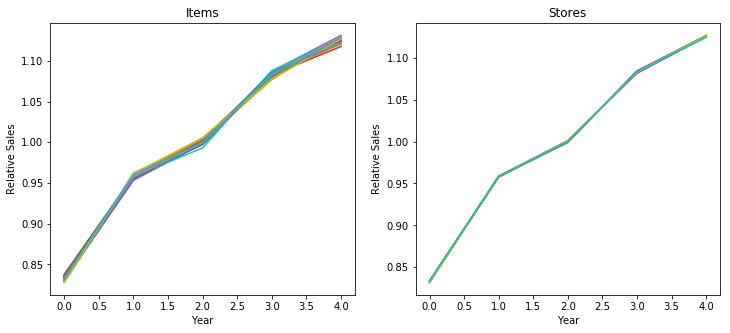

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0))
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0))
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()

### Changes by month

All items and stores seem to share a common pattern in sales over the months as well.


In [12]:
agg_month_item = pd.pivot_table(data, index='month', columns='item',
                                values='sales', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(data, index='month', columns='store',
                                 values='sales', aggfunc=np.mean).values

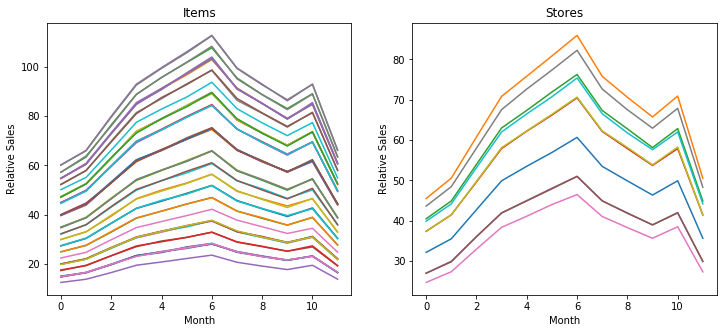

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item)
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_month_store)
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()

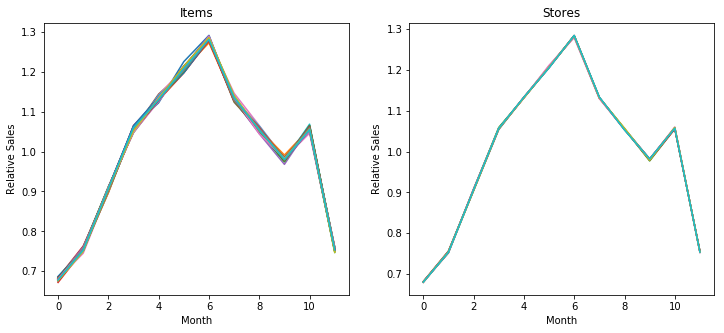

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0))
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0))
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()

### Changes by day of the week

All items and stores also seem to share a common pattern in sales over the days of the week as well.

In [18]:
agg_dow_item = pd.pivot_table(data, index='dayofweek', columns='item',
                              values='sales', aggfunc=np.mean).values
agg_dow_store = pd.pivot_table(data, index='dayofweek', columns='store',
                               values='sales', aggfunc=np.mean).values

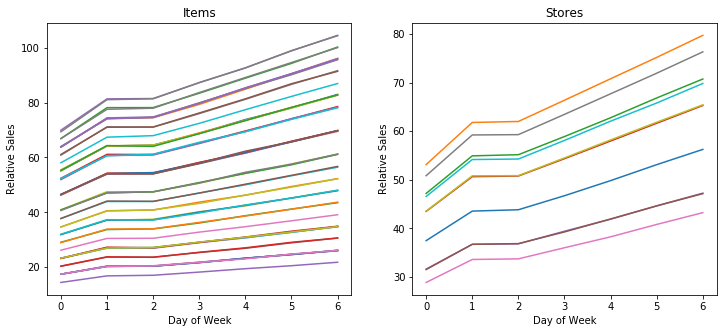

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_dow_item)
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_dow_store)
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()

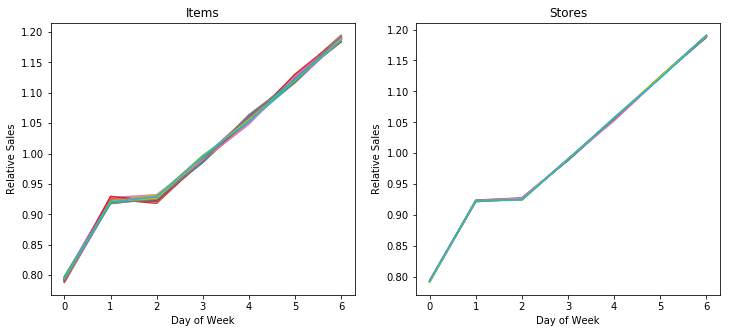

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_dow_item / agg_dow_item.mean(0))
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_dow_store / agg_dow_store.mean(0))
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()

### Are these patterns degenerate?

This is an important question. Not checking for degeneracies in the data can lead to missing important trends in complex datasets. For example, when looking at the monthly pattenrs, we average over all days of the month, years and either items or stores. But what if sales have a multi-dimensional dependence on two of these parameters that isn't easily separable? So, always check for degeneracies in the data!

In [22]:
agg_dow_month = pd.pivot_table(data, index='dayofweek', columns='month',
                               values='sales', aggfunc=np.mean).values
agg_month_year = pd.pivot_table(data, index='month', columns='year',
                                values='sales', aggfunc=np.mean).values
agg_dow_year = pd.pivot_table(data, index='dayofweek', columns='year',
                              values='sales', aggfunc=np.mean).values

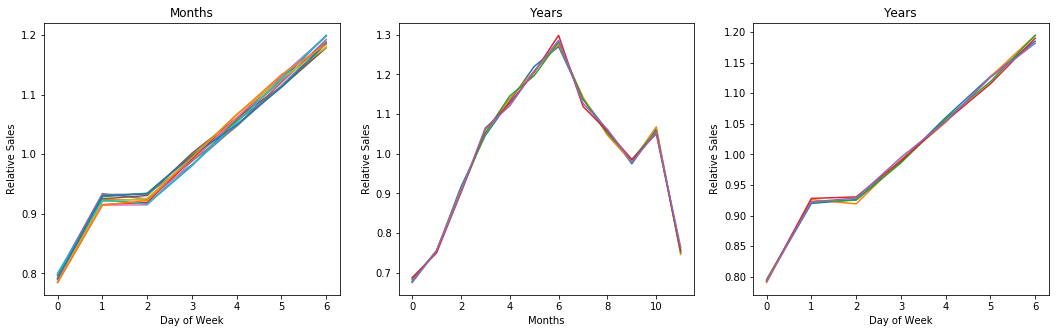

In [23]:
plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.plot(agg_dow_month / agg_dow_month.mean(0))
plt.title("Months")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")

plt.subplot(132)
plt.plot(agg_month_year / agg_month_year.mean(0))
plt.title("Years")
plt.xlabel("Months")
plt.ylabel("Relative Sales")

plt.subplot(133)
plt.plot(agg_dow_year / agg_dow_year.mean(0))
plt.title("Years")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")

plt.show()

In this case, however, there don't seem to be any sneaky degeneracies. We can effectively treat the "month", "year", "day of the week", "item" and "store" as completely independent modifiers to sales prediction. This leads to a *very very simple* prediction model.

"Relative sales" in the plots above are the sales relative to the average. Since there are very regular patterns in the "month", "day of week", and "year" trends. All we have to do is simply memorize these trends and apply them to our predictions by multiplying them to the expected average sales. We get the expected average sales for an item at a store from the historical numbers in the training set.

### What about the item-store relationship?

In [24]:
agg_store_item = pd.pivot_table(data, index='store', columns='item',
                                values='sales', aggfunc=np.mean).values

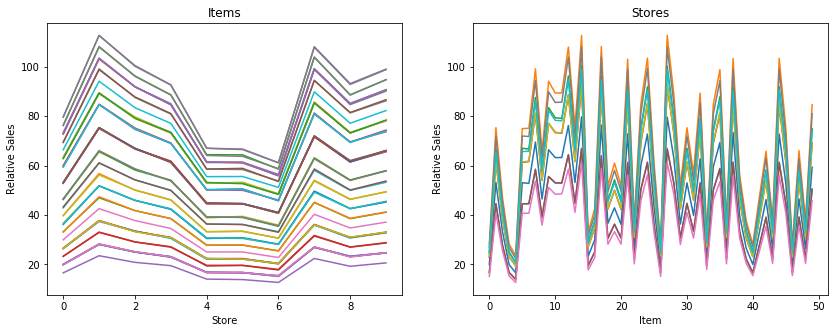

In [26]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item)
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_store_item.T)
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()

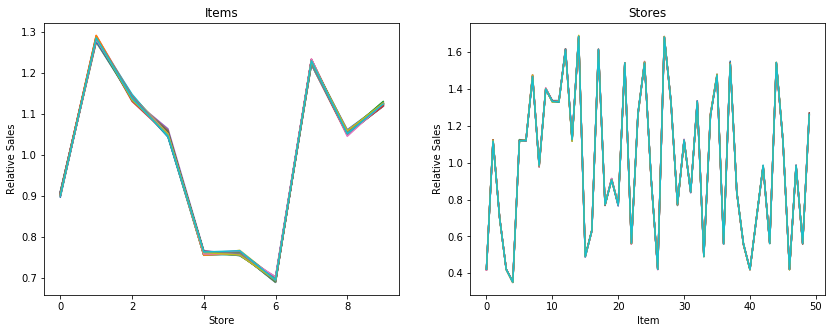

In [25]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item / agg_store_item.mean(0))
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_store_item.T / agg_store_item.T.mean(0))
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()

Same here. Just a constant pattern and no degeneracies. So, you just need a model for how items sell at different stores, which is easily captured by an average sales look-up table or yet another "relative sales" pattern model.

> *Aside: Based on the extremely regularity of the data, how neat it is, and how few degeneracies there are - I am fairly confident this is probably simulated data.*

## Writing the "slightly better predictor"

We just need an item-store average sale look-up table, and then the "day of week", "monthly", "yearly" models.

In [27]:
# Item-Store Look Up Table
store_item_table = pd.pivot_table(data, index='store', columns='item',
                                  values='sales', aggfunc=np.mean)
display(store_item_table)

# Monthly pattern
month_table = pd.pivot_table(data, index='month', values='sales', aggfunc=np.mean)
month_table.sales /= grand_avg

# Day of week pattern
dow_table = pd.pivot_table(data, index='dayofweek', values='sales', aggfunc=np.mean)
dow_table.sales /= grand_avg

# Yearly growth pattern
year_table = pd.pivot_table(data, index='year', values='sales', aggfunc=np.mean)
year_table /= grand_avg

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,
1,19.971522,53.148959,33.208105,19.956188,16.612815,53.060789,52.783680,69.472070,46.504929,66.354326,...,20.002738,33.105696,46.242607,26.594195,72.720701,52.845016,19.814348,46.546002,26.461665,59.342826
2,28.173604,75.316539,46.992333,28.234940,23.540526,74.945235,75.058598,99.090361,65.478094,94.097481,...,28.069551,47.368018,65.785323,37.785871,103.381161,75.219606,28.187842,66.028478,37.711939,84.622125
3,25.070099,66.804491,41.771084,25.116101,20.857612,67.007119,66.647864,87.517525,58.486857,83.387733,...,24.989047,41.797371,58.197700,33.386090,91.851041,66.748083,25.120482,58.700986,33.259584,74.958379
4,22.938664,61.715225,38.548193,23.086528,19.525192,61.270537,61.625411,80.819825,54.043812,77.047645,...,23.168127,38.539978,54.018620,30.952355,84.687295,61.420044,23.114458,53.765608,30.840635,68.921687
5,16.739321,44.488499,27.835706,16.776561,14.086528,44.564622,44.535597,58.565717,38.837349,55.509858,...,16.830778,27.730559,39.163198,22.415115,61.427163,44.734940,16.699343,39.281490,22.371851,50.319277
6,16.717963,44.533954,27.811062,16.754107,13.893209,44.503834,44.599124,58.385542,39.460022,55.565170,...,16.607338,27.893209,39.034502,22.322563,61.142935,44.539978,16.708653,39.052574,22.181271,50.516429
7,15.159365,40.717963,25.531216,15.358160,12.733844,40.703724,40.709748,53.723987,35.901972,51.156627,...,15.471522,25.435926,35.426068,20.446331,55.905805,40.828587,15.479189,35.624315,20.406353,45.823658
8,26.983571,71.656627,45.076123,26.948521,22.427711,71.958379,71.730559,94.461117,63.193319,89.818182,...,27.036145,45.144031,62.980285,36.194414,98.941402,72.004929,27.150055,62.737130,36.035049,80.972070
9,23.325849,61.792442,38.535049,23.150055,19.272180,61.412377,61.812158,81.287514,54.105696,77.105148,...,23.191128,38.643483,54.152793,30.968237,85.093647,62.010953,23.003286,53.976999,31.052574,69.308324


In [28]:
years = np.arange(2013, 2019)
annual_sales_avg = year_table.values.squeeze()

p1 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 1))
p2 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 2))

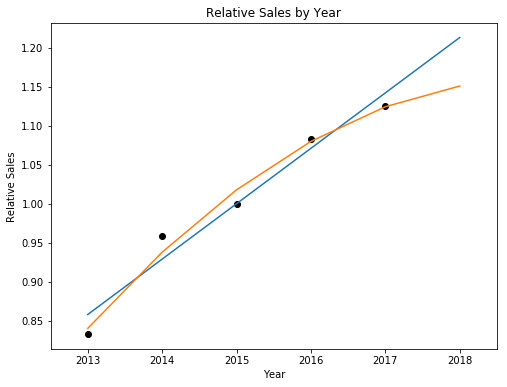

2018 Relative Sales by Degree-1 (Linear) Fit = 1.2132
2018 Relative Sales by Degree-2 (Quadratic) Fit = 1.1509


In [29]:
plt.figure(figsize=(8,6))
plt.plot(years[:-1], annual_sales_avg, 'ko')
plt.plot(years, p1(years), 'C0-')
plt.plot(years, p2(years), 'C1-')
plt.xlim(2012.5, 2018.5)
plt.title("Relative Sales by Year")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.show()

print(f"2018 Relative Sales by Degree-1 (Linear) Fit = {p1(2018):.4f}")
print(f"2018 Relative Sales by Degree-2 (Quadratic) Fit = {p2(2018):.4f}")

# We pick the quadratic fit
annual_growth = p2

We can do a simple linear regression on the yearly growth datapoints. But if you look carefully, you can tell that the growth is slowing down. The quadratic fit works better since it better captures the curvature in the growth curve. Since we only have 5 points, this is the highest degree polynomial fit you should do to avoid overfitting.

Now, we write the predictor. It's quite simple! When we are asked to predict the sales of Item X at Store Y on, say, a Monday in February - all we have to do is to look up the historical average of the sales of Item X at Store Y and then multiply it by a factor corresponding to Monday and then a factor corresponding to February to account for the seasonal and weekly changes in item sales at the stores. Finally, we multiply by the annual growth factor for the year we are predicting for. And thus, we have a very simple forecast of the item's sales.

This predictor will run quite fast and should parse through the whole test dataset in less than 20 seconds. A significant improvement over the "dumb" prediction method both in accuracy and compute efficiency.

In [ ]:
def slightly_better(test, submission):
    submission[['sales']] = submission[['sales']].astype(np.float64)
    for _, row in test.iterrows():
        dow, month, year = row.name.dayofweek, row.name.month, row.name.year
        item, store = row['item'], row['store']
        base_sales = store_item_table.at[store, item]
        mul = month_table.at[month, 'sales'] * dow_table.at[dow, 'sales']
        pred_sales = base_sales * mul * annual_growth(year)
        submission.at[row['id'], 'sales'] = pred_sales
    return submission

slightly_better_pred = slightly_better(test, sample_sub.copy())
slightly_better_pred.to_csv("sbp_float.csv", index=False)

# Round to nearest integer (if you want an integer submission)
sbp_round = slightly_better_pred.copy()
sbp_round['sales'] = np.round(sbp_round['sales']).astype(int)
sbp_round.to_csv("sbp_round.csv", index=False)

### This solution gets a public score of 13.88569, and 13.87573 when rounding to the nearest integer!
**(A nice improvement especially given the simplicity of the solution)**

*Note: Rounding to the nearest integer likely gives a marginally better score because the ground truth values are integers and rounding on average gets you closer to the actual values if your model is good.*

# How can we do better?

Now that we have a very simple and effective model, there are many different direction we can go in improving the model. Here are a few ideas:

* Try seeing how well the model does on the training set itself and what the SMAPE metric looks like. Does the noise properties make sense? Is there a trend in the SMAPE? Finding regions of high SMAPE in the training set can be a rough indicator of where accuracy is taking a hit on the test set!

* Is the sales data normally distributed around the trends we found? If not, that can distort our predictions. Correctly for the noise distribution can help lower the SMAPE (and ultimately, make a better predictor).

* Are there other trends we missed? ***Try not to depend on black-box algorithms!*** Use your domain knowledge of stores and think about what could affect item sales.

# Conclusion

While it is enticing to throw a complicated magical algorithm at any and all datasets blindly, it is usually easier and more meaningful to simply think about the data and come up with simpler models. This kernel was written to show how easy-to-understand methods such as finding averages and simple regressions used under the guidance of domain knowledge (i.e., thinking about how stores work) do equally as well, if not much better than overly-complicated algorithms.
